* ライブラリ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jpholiday
sns.set(font='Yu Gothic')

import statistics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

import xgboost
import lightgbm
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

### データ読込

In [2]:
df =  pd.read_csv('./tokyo-electricity.csv')
df['Datetime'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])
#df = df.set_index('Datetime')
df = df.drop(['DATE', 'TIME'], axis=1)
origin = df.copy()

df['実績'] = np.log(df['実績']+1)

In [3]:
df.head()

,実績,Datetime
0,7.846199,2016-04-01 00:00:00
1,7.797291,2016-04-01 01:00:00
2,7.780721,2016-04-01 02:00:00
3,7.773174,2016-04-01 03:00:00
4,7.779467,2016-04-01 04:00:00


### 特徴量作成

ラグlagは、一ヶ月先（24時間×30日）、又は3ヶ月先（24時間×90日）にする

In [4]:
# カレンダー特徴
# ラグlagは、一ヶ月先、又は3ヶ月先にする
def feature_create(df, lag):
    df['Month'] = df['Datetime'].dt.month
    df['Day'] = df['Datetime'].dt.day
    df['DayofWeek'] = df['Datetime'].dt.dayofweek
    df['Hour'] = df['Datetime'].dt.hour
    df['IsHoliday'] = df['Datetime'].map(jpholiday.is_holiday).astype(int)
  
    df[f"Shift_lag"] = df["実績"].shift(lag)
    # 差分の作成
    df["Diff_lag"] = df["実績"].diff(lag)
    # 移動平均の作成
    df["Mean_lag"] = df["実績"].rolling(lag).mean()
    #df["Mean_lag7"] = df["実績"].rolling(lag*7).mean()
    # 中央値、最大値、最小値の作成
    df["Median_lag"] = df["実績"].rolling(lag).median()
    #df["Median_lag7"] = df["実績"].rolling(lag*7).median()
    df["Max_lag"] = df["実績"].rolling(lag).max()
    #df["Max_lag7"] = df["実績"].rolling(lag*7).max()
    df["Min_lag"] = df["実績"].rolling(lag).min()
    #df["Min_lag7"] = df["実績"].rolling(lag*7).min()
    df.dropna(inplace=True)
    df.set_index('Datetime', inplace=True)
    
    return df

In [5]:
# カレンダー特徴
def time_feature_create(df):
    df['Month'] = df['Datetime'].dt.month
    df['Day'] = df['Datetime'].dt.day
    df['DayofWeek'] = df['Datetime'].dt.dayofweek
    df['Hour'] = df['Datetime'].dt.hour
    df['IsHoliday'] = df['Datetime'].map(jpholiday.is_holiday).astype(int)

    df.dropna(inplace=True)
    df.set_index('Datetime', inplace=True)
    
    return df

In [6]:
lag = 24*30
df = feature_create(df, lag)
df.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 56256 entries, 2016-05-01 00:00:00 to 2022-09-30 23:00:00

Data columns (total 12 columns):

 #   Column      Non-Null Count  Dtype  

---  ------      --------------  -----  

 0   実績          56256 non-null  float64

 1   Month       56256 non-null  int64  

 2   Day         56256 non-null  int64  

 3   DayofWeek   56256 non-null  int64  

 4   Hour        56256 non-null  int64  

 5   IsHoliday   56256 non-null  int64  

 6   Shift_lag   56256 non-null  float64

 7   Diff_lag    56256 non-null  float64

 8   Mean_lag    56256 non-null  float64

 9   Median_lag  56256 non-null  float64

 10  Max_lag     56256 non-null  float64

 11  Min_lag     56256 non-null  float64

dtypes: float64(7), int64(5)

memory usage: 5.6 MB


In [7]:
df.head()

,実績,Month,Day,DayofWeek,Hour,IsHoliday,Shift_lag,Diff_lag,Mean_lag,Median_lag,Max_lag,Min_lag
Datetime,,,,,,,,,,,,
2016-05-01 00:00:00,7.709757,5,1,6,0,0,7.846199,-0.136442,7.960102,7.965718,8.239857,7.673223
2016-05-01 01:00:00,7.659643,5,1,6,1,0,7.797291,-0.137648,7.959911,7.965718,8.239857,7.659643
2016-05-01 02:00:00,7.653969,5,1,6,2,0,7.780721,-0.126752,7.959735,7.965718,8.239857,7.653969
2016-05-01 03:00:00,7.659643,5,1,6,3,0,7.773174,-0.113531,7.959577,7.965718,8.239857,7.653969
2016-05-01 04:00:00,7.661056,5,1,6,4,0,7.779467,-0.118411,7.959413,7.965718,8.239857,7.653969


In [8]:
len(origin)-len(df), len(df)/len(origin)

(720, 0.987363100252738)

### 交差検証

In [9]:
X = df.drop('実績', axis='columns')
y = df['実績']

* 学習評価関数

In [10]:
def model_evaluate(model, X, y):
    tscv = TimeSeriesSplit()
    mape_list = []
    rmse_list = []
    mae_list = []
    r2_list = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # 指数関数変換
        y_pred = np.exp(y_pred+1)-1
        y_test = np.exp(y_test+1)-1
        #
        mape = mean_absolute_percentage_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mape_list.append(mape)
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)

    print(
        f"{model}\n"
        f"MAPE平均値:     {statistics.mean(mape_list):.3f} （+/- {statistics.stdev(mape_list):.3f}）\n"
        f"RMSE平均値:     {statistics.mean(rmse_list):.3f} （+/- {statistics.stdev(rmse_list):.3f}）\n"
        f"MAE平均値:      {statistics.mean(mae_list):.3f} （+/- {statistics.stdev(mae_list):.3f}）\n"
        f"R2平均値:       {statistics.mean(r2_list):.3f} （+/- {statistics.stdev(r2_list):.3f}）\n\n"
    )

In [11]:
xgb = xgboost.XGBRFRegressor()
lgbm = lightgbm.LGBMRegressor()
rf = RandomForestRegressor()
mlp = MLPRegressor()

model_list = [lgbm]

for model in model_list:    
    model_evaluate(model, X, y)

LGBMRegressor()

MAPE平均値:     0.010 （+/- 0.001）

RMSE平均値:     148.738 （+/- 28.019）

MAE平均値:      87.404 （+/- 7.142）

R2平均値:       0.993 （+/- 0.003）






### 予測- 時間・ラグ特徴量（lag=24×30）

In [12]:
df =  pd.read_csv('./tokyo-electricity.csv')
df['Datetime'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])
#df = df.set_index('Datetime')
df = df.drop(['DATE', 'TIME'], axis=1)
df['実績'] = np.log(df['実績']+1)

lag = 24*30
df = feature_create(df, lag)

df_train = df[:-lag]
df_test = df[-lag:]

X = df_train.drop('実績', axis='columns')
y = df_train['実績']

X_test = df_test.drop('実績', axis='columns')
y_test = df_test['実績']

In [13]:
lgbm = lightgbm.LGBMRegressor()
lgbm.fit(X, y)
y_pred = lgbm.predict(X_test)

mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(
    f"MAPE:     {mape:.3f}\n"
    f"RMSE:     {rmse:.3f}\n"
    f"MAE:      {mae:.3f}\n"
    f"R2:       {r2:.3f}\n\n"
)

MAPE:     0.001

RMSE:     0.014

MAE:      0.009

R2:       0.995






### 予測- 時間特徴量（lag=24×30）

In [30]:
df =  pd.read_csv('./tokyo-electricity.csv')
df['Datetime'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])
#df = df.set_index('Datetime')
df = df.drop(['DATE', 'TIME'], axis=1)

lag = 24*30
df = time_feature_create(df)

df_train = df[:-lag]
df_test = df[-lag:]

X = df_train.drop('実績', axis='columns')
y = df_train['実績']

X_test = df_test.drop('実績', axis='columns')
y_test = df_test['実績']

In [31]:
lgbm = lightgbm.LGBMRegressor()
lgbm.fit(X, y)
y_pred = lgbm.predict(X_test)

mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(
    f"MAPE:     {mape:.3f}\n"
    f"RMSE:     {rmse:.3f}\n"
    f"MAE:      {mae:.3f}\n"
    f"R2:       {r2:.3f}\n\n"
)

MAPE:     0.056

RMSE:     248.097

MAE:      188.901

R2:       0.858






### 予測- 時間・ラグ特徴量（lag=24×90）

In [32]:
df =  pd.read_csv('./tokyo-electricity.csv')
df['Datetime'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])
#df = df.set_index('Datetime')
df = df.drop(['DATE', 'TIME'], axis=1)

lag = 24*90
df = feature_create(df, lag)

df_train = df[:-lag]
df_test = df[-lag:]

X = df_train.drop('実績', axis='columns')
y = df_train['実績']

X_test = df_test.drop('実績', axis='columns')
y_test = df_test['実績']

In [33]:
lgbm = lightgbm.LGBMRegressor()
lgbm.fit(X, y)
y_pred = lgbm.predict(X_test)

mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(
    f"MAPE:     {mape:.3f}\n"
    f"RMSE:     {rmse:.3f}\n"
    f"MAE:      {mae:.3f}\n"
    f"R2:       {r2:.3f}\n\n"
)

MAPE:     0.008

RMSE:     59.718

MAE:      28.304

R2:       0.994






### 予測- 時間特徴量（lag=24×90）

In [34]:
df =  pd.read_csv('./tokyo-electricity.csv')
df['Datetime'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])
#df = df.set_index('Datetime')
df = df.drop(['DATE', 'TIME'], axis=1)

lag = 24*90
df = time_feature_create(df)

df_train = df[:-lag]
df_test = df[-lag:]

X = df_train.drop('実績', axis='columns')
y = df_train['実績']

X_test = df_test.drop('実績', axis='columns')
y_test = df_test['実績']

In [35]:
lgbm = lightgbm.LGBMRegressor()
lgbm.fit(X, y)
y_pred = lgbm.predict(X_test)

mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(
    f"MAPE:     {mape:.3f}\n"
    f"RMSE:     {rmse:.3f}\n"
    f"MAE:      {mae:.3f}\n"
    f"R2:       {r2:.3f}\n\n"
)

MAPE:     0.070

RMSE:     339.564

MAE:      255.751

R2:       0.815






### 予測- 時間・ラグ特徴量（lag=24×365）

* 特徴量作成

In [14]:
df =  pd.read_csv('./tokyo-electricity.csv')
df['Datetime'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])
#df = df.set_index('Datetime')
df = df.drop(['DATE', 'TIME'], axis=1)
df['実績'] = np.log(df['実績']+1)
origin = df.copy()

lag = 24*365
df = feature_create(df, lag)

df_train = df[:-lag]
df_test = df[-lag:]

X = df_train.drop('実績', axis='columns')
y = df_train['実績']

X_test = df_test.drop('実績', axis='columns')
y_test = df_test['実績']

* ベースラインの結果

In [31]:
# 特徴量の平均値をベースラインの予測結果とする
base_df = X_test.copy()
base_df['Base'] = df[['Shift_lag', 'Diff_lag', 'Mean_lag', 'Median_lag', 'Max_lag', 'Min_lag']].mean(axis=1)
y_base = np.exp(base_df['Base'] +1)-1

y_pred = y_base
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(
    f"MAPE:     {mape:.3f}\n"
    f"RMSE:     {rmse:.3f}\n"
    f"MAE:      {mae:.3f}\n"
    f"R2:       {r2:.3f}\n\n"
)

MAPE:     0.734

RMSE:     6894.370

MAE:      6644.666

R2:       -11.900






In [34]:
# ラグを予測結果とする
y_pred = base_df['Shift_lag']
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(
    f"MAPE:     {mape:.3f}\n"
    f"RMSE:     {rmse:.3f}\n"
    f"MAE:      {mae:.3f}\n"
    f"R2:       {r2:.3f}\n\n"
)

MAPE:     0.999

RMSE:     9133.089

MAE:      8929.129

R2:       -21.638






* 予測の結果

In [15]:
lgbm = lightgbm.LGBMRegressor()
lgbm.fit(X, y)
y_pred = lgbm.predict(X_test)

# 指数関数変換
y_pred = np.exp(y_pred+1)-1
y_test = np.exp(y_test+1)-1
#
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(
    f"MAPE:     {mape:.3f}\n"
    f"RMSE:     {rmse:.3f}\n"
    f"MAE:      {mae:.3f}\n"
    f"R2:       {r2:.3f}\n\n"
)

MAPE:     0.005

RMSE:     101.815

MAE:      45.736

R2:       0.997






In [16]:
len(origin)-len(df), (len(origin)-len(df))/len(origin)

(8760, 0.15374894692502106)

In [17]:
df_pred = df_test[['実績']].copy()
df_test['実績'] = y_test
df_pred['実績'] = y_pred
df_pred

/home/kou/anaconda3/envs/bert_pip/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  


,実績
Datetime,
2021-10-01 00:00:00,6802.141300
2021-10-01 01:00:00,6524.654396
2021-10-01 02:00:00,6358.773950
2021-10-01 03:00:00,6454.913790
2021-10-01 04:00:00,6503.827677
...,...
2022-09-30 19:00:00,8969.006684
2022-09-30 20:00:00,8438.632153
2022-09-30 21:00:00,7939.977149


findfont: Font family ['Yu Gothic'] not found. Falling back to DejaVu Sans.


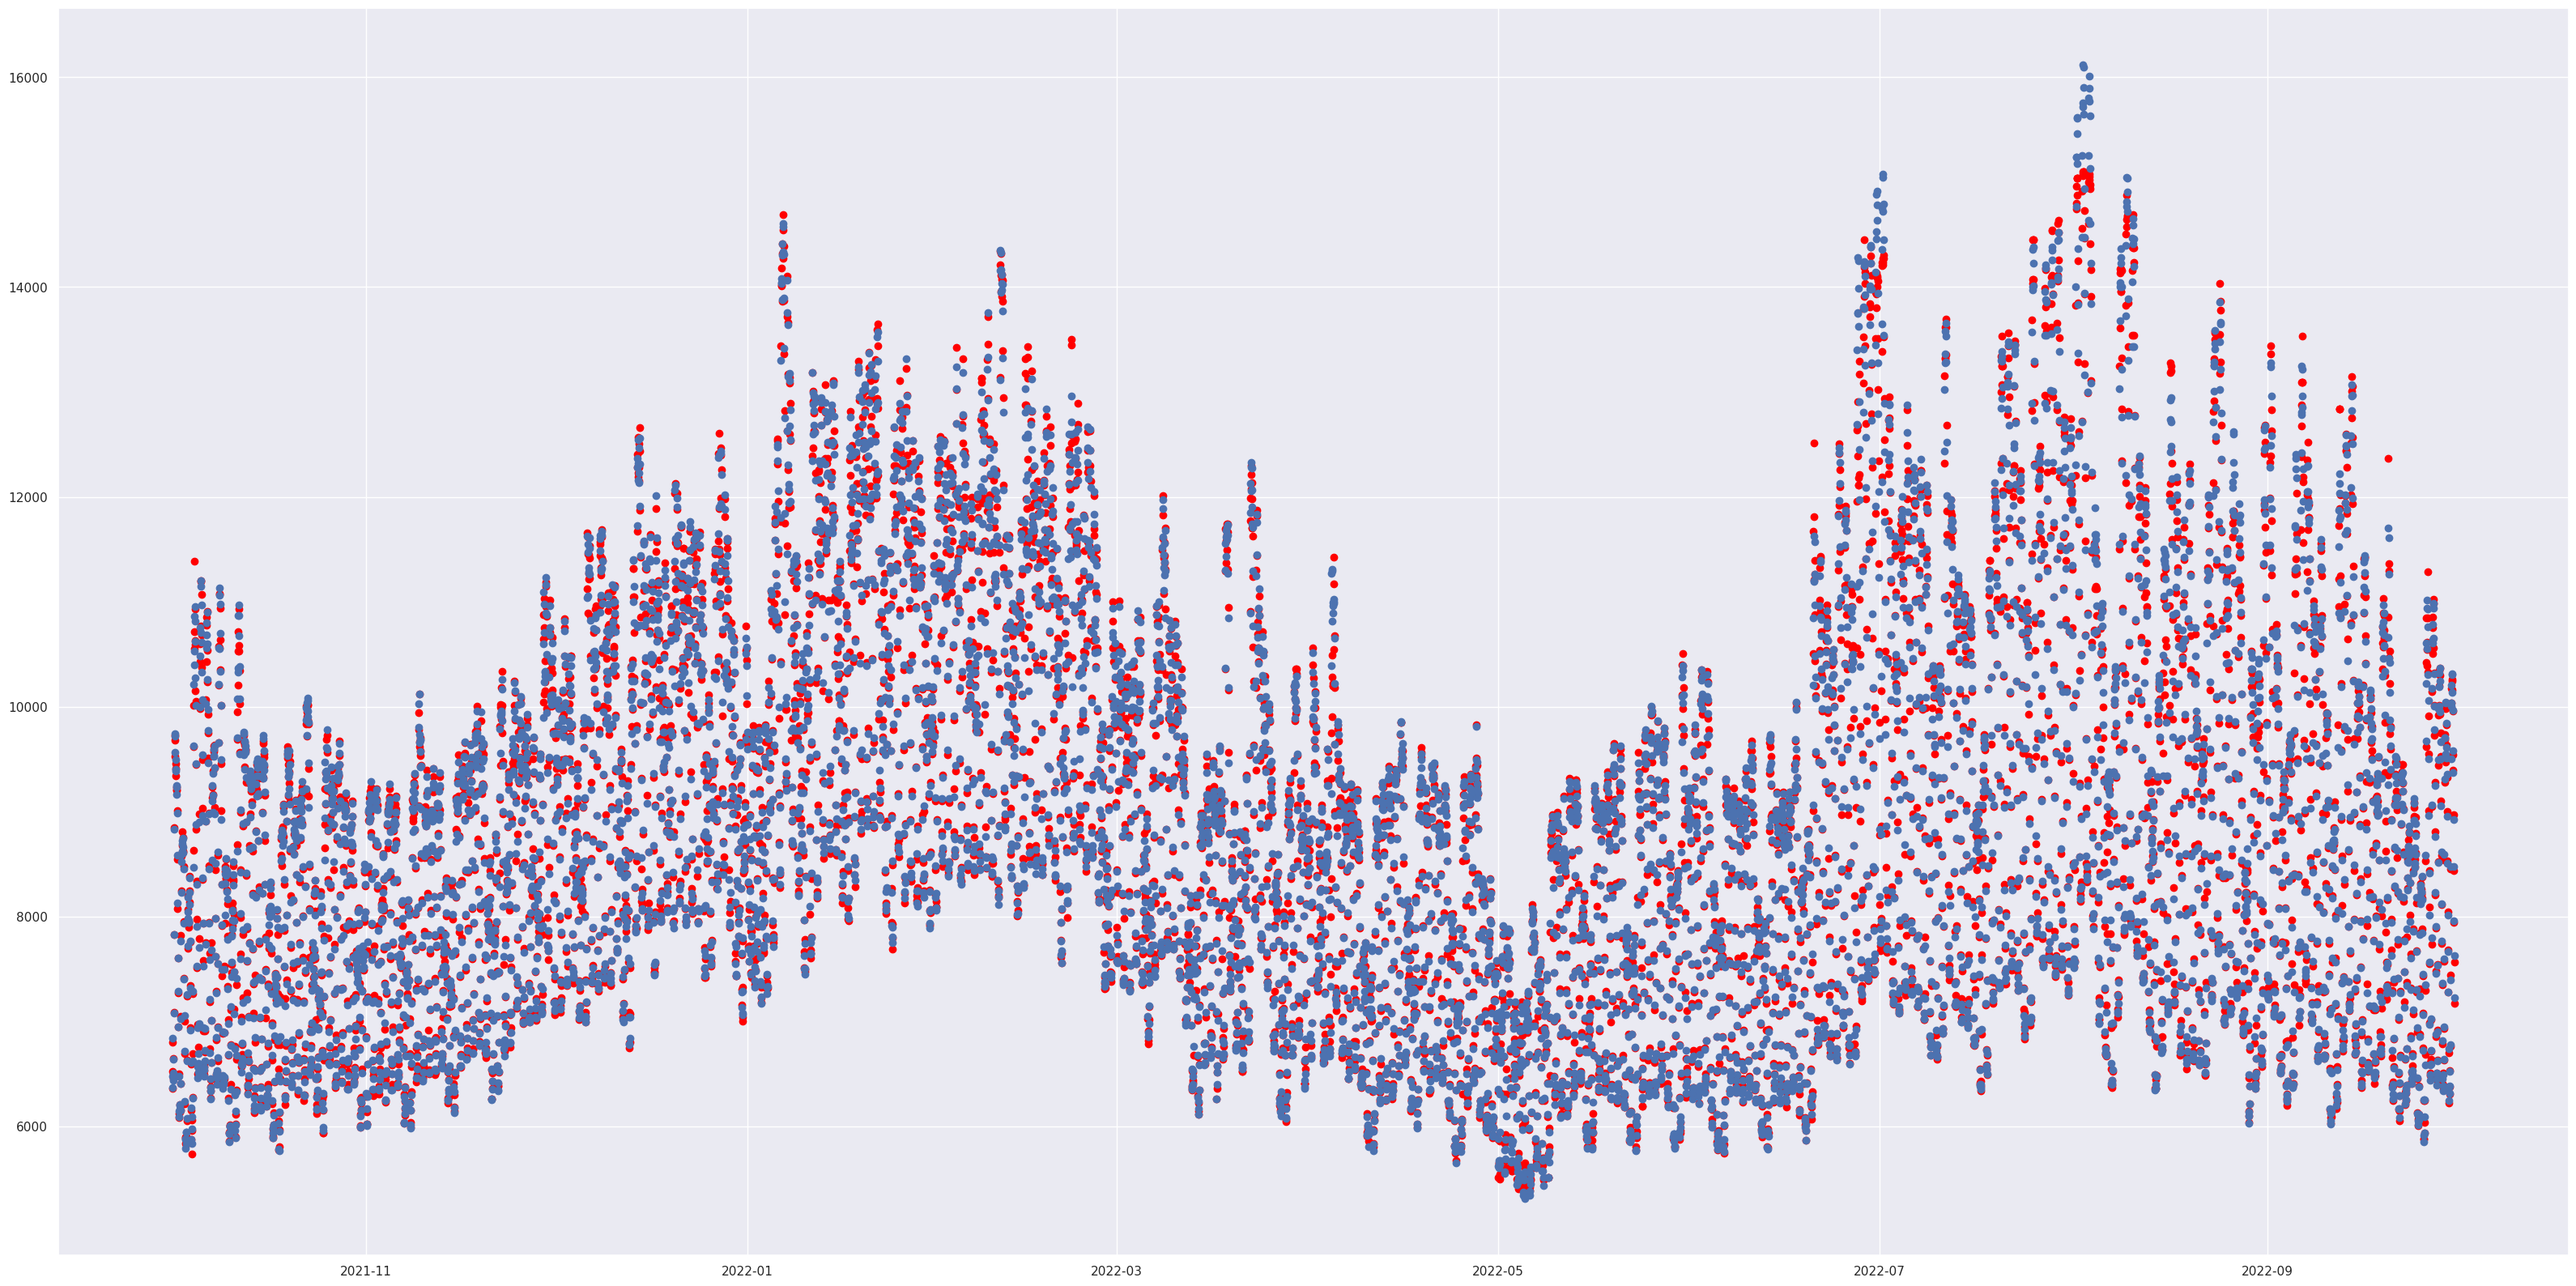

In [18]:
plt.figure(figsize=(40,20))
#plt.plot(df_train.index, df_train['実績'].rolling(24*7).mean())
plt.scatter(df_pred.index, df_pred['実績'], color='red')
plt.scatter(df_test.index, df_test['実績'])

### 予測- ラグのみの特徴量（lag=24×365）

* 特徴量作成

In [ ]:
df =  pd.read_csv('./tokyo-electricity.csv')
df['Datetime'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])
#df = df.set_index('Datetime')
df = df.drop(['DATE', 'TIME'], axis=1)
df['実績'] = np.log(df['実績']+1)
origin = df.copy()

lag = 24*365
df = feature_create(df, lag)

df_train = df[:-lag]
df_test = df[-lag:]

X = df_train.drop('実績', axis='columns')
y = df_train['実績']

X_test = df_test.drop('実績', axis='columns')
y_test = df_test['実績']

* ベースラインの結果１

In [ ]:
# 特徴量の平均値をベースラインの予測結果とする
base_df = X_test.copy()
base_df['Base'] = df[['Shift_lag', 'Diff_lag', 'Mean_lag', 'Median_lag', 'Max_lag', 'Min_lag']].mean(axis=1)
y_base = np.exp(base_df['Base'] +1)-1

y_pred = y_base
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(
    f"MAPE:     {mape:.3f}\n"
    f"RMSE:     {rmse:.3f}\n"
    f"MAE:      {mae:.3f}\n"
    f"R2:       {r2:.3f}\n\n"
)

MAPE:     0.734

RMSE:     6894.370

MAE:      6644.666

R2:       -11.900






* ベースラインの結果２

In [ ]:
# ラグを予測結果とする
y_pred = base_df['Shift_lag']
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(
    f"MAPE:     {mape:.3f}\n"
    f"RMSE:     {rmse:.3f}\n"
    f"MAE:      {mae:.3f}\n"
    f"R2:       {r2:.3f}\n\n"
)

MAPE:     0.999

RMSE:     9133.089

MAE:      8929.129

R2:       -21.638






* 予測の結果

In [ ]:
lgbm = lightgbm.LGBMRegressor()
lgbm.fit(X, y)
y_pred = lgbm.predict(X_test)

# 指数関数変換
y_pred = np.exp(y_pred+1)-1
y_test = np.exp(y_test+1)-1
#
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(
    f"MAPE:     {mape:.3f}\n"
    f"RMSE:     {rmse:.3f}\n"
    f"MAE:      {mae:.3f}\n"
    f"R2:       {r2:.3f}\n\n"
)

MAPE:     0.005

RMSE:     101.815

MAE:      45.736

R2:       0.997






In [ ]:
len(origin)-len(df), (len(origin)-len(df))/len(origin)

(8760, 0.15374894692502106)

In [ ]:
df_pred = df_test[['実績']].copy()
df_test['実績'] = y_test
df_pred['実績'] = y_pred
df_pred

/home/kou/anaconda3/envs/bert_pip/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  


,実績
Datetime,
2021-10-01 00:00:00,6802.141300
2021-10-01 01:00:00,6524.654396
2021-10-01 02:00:00,6358.773950
2021-10-01 03:00:00,6454.913790
2021-10-01 04:00:00,6503.827677
...,...
2022-09-30 19:00:00,8969.006684
2022-09-30 20:00:00,8438.632153
2022-09-30 21:00:00,7939.977149


findfont: Font family ['Yu Gothic'] not found. Falling back to DejaVu Sans.


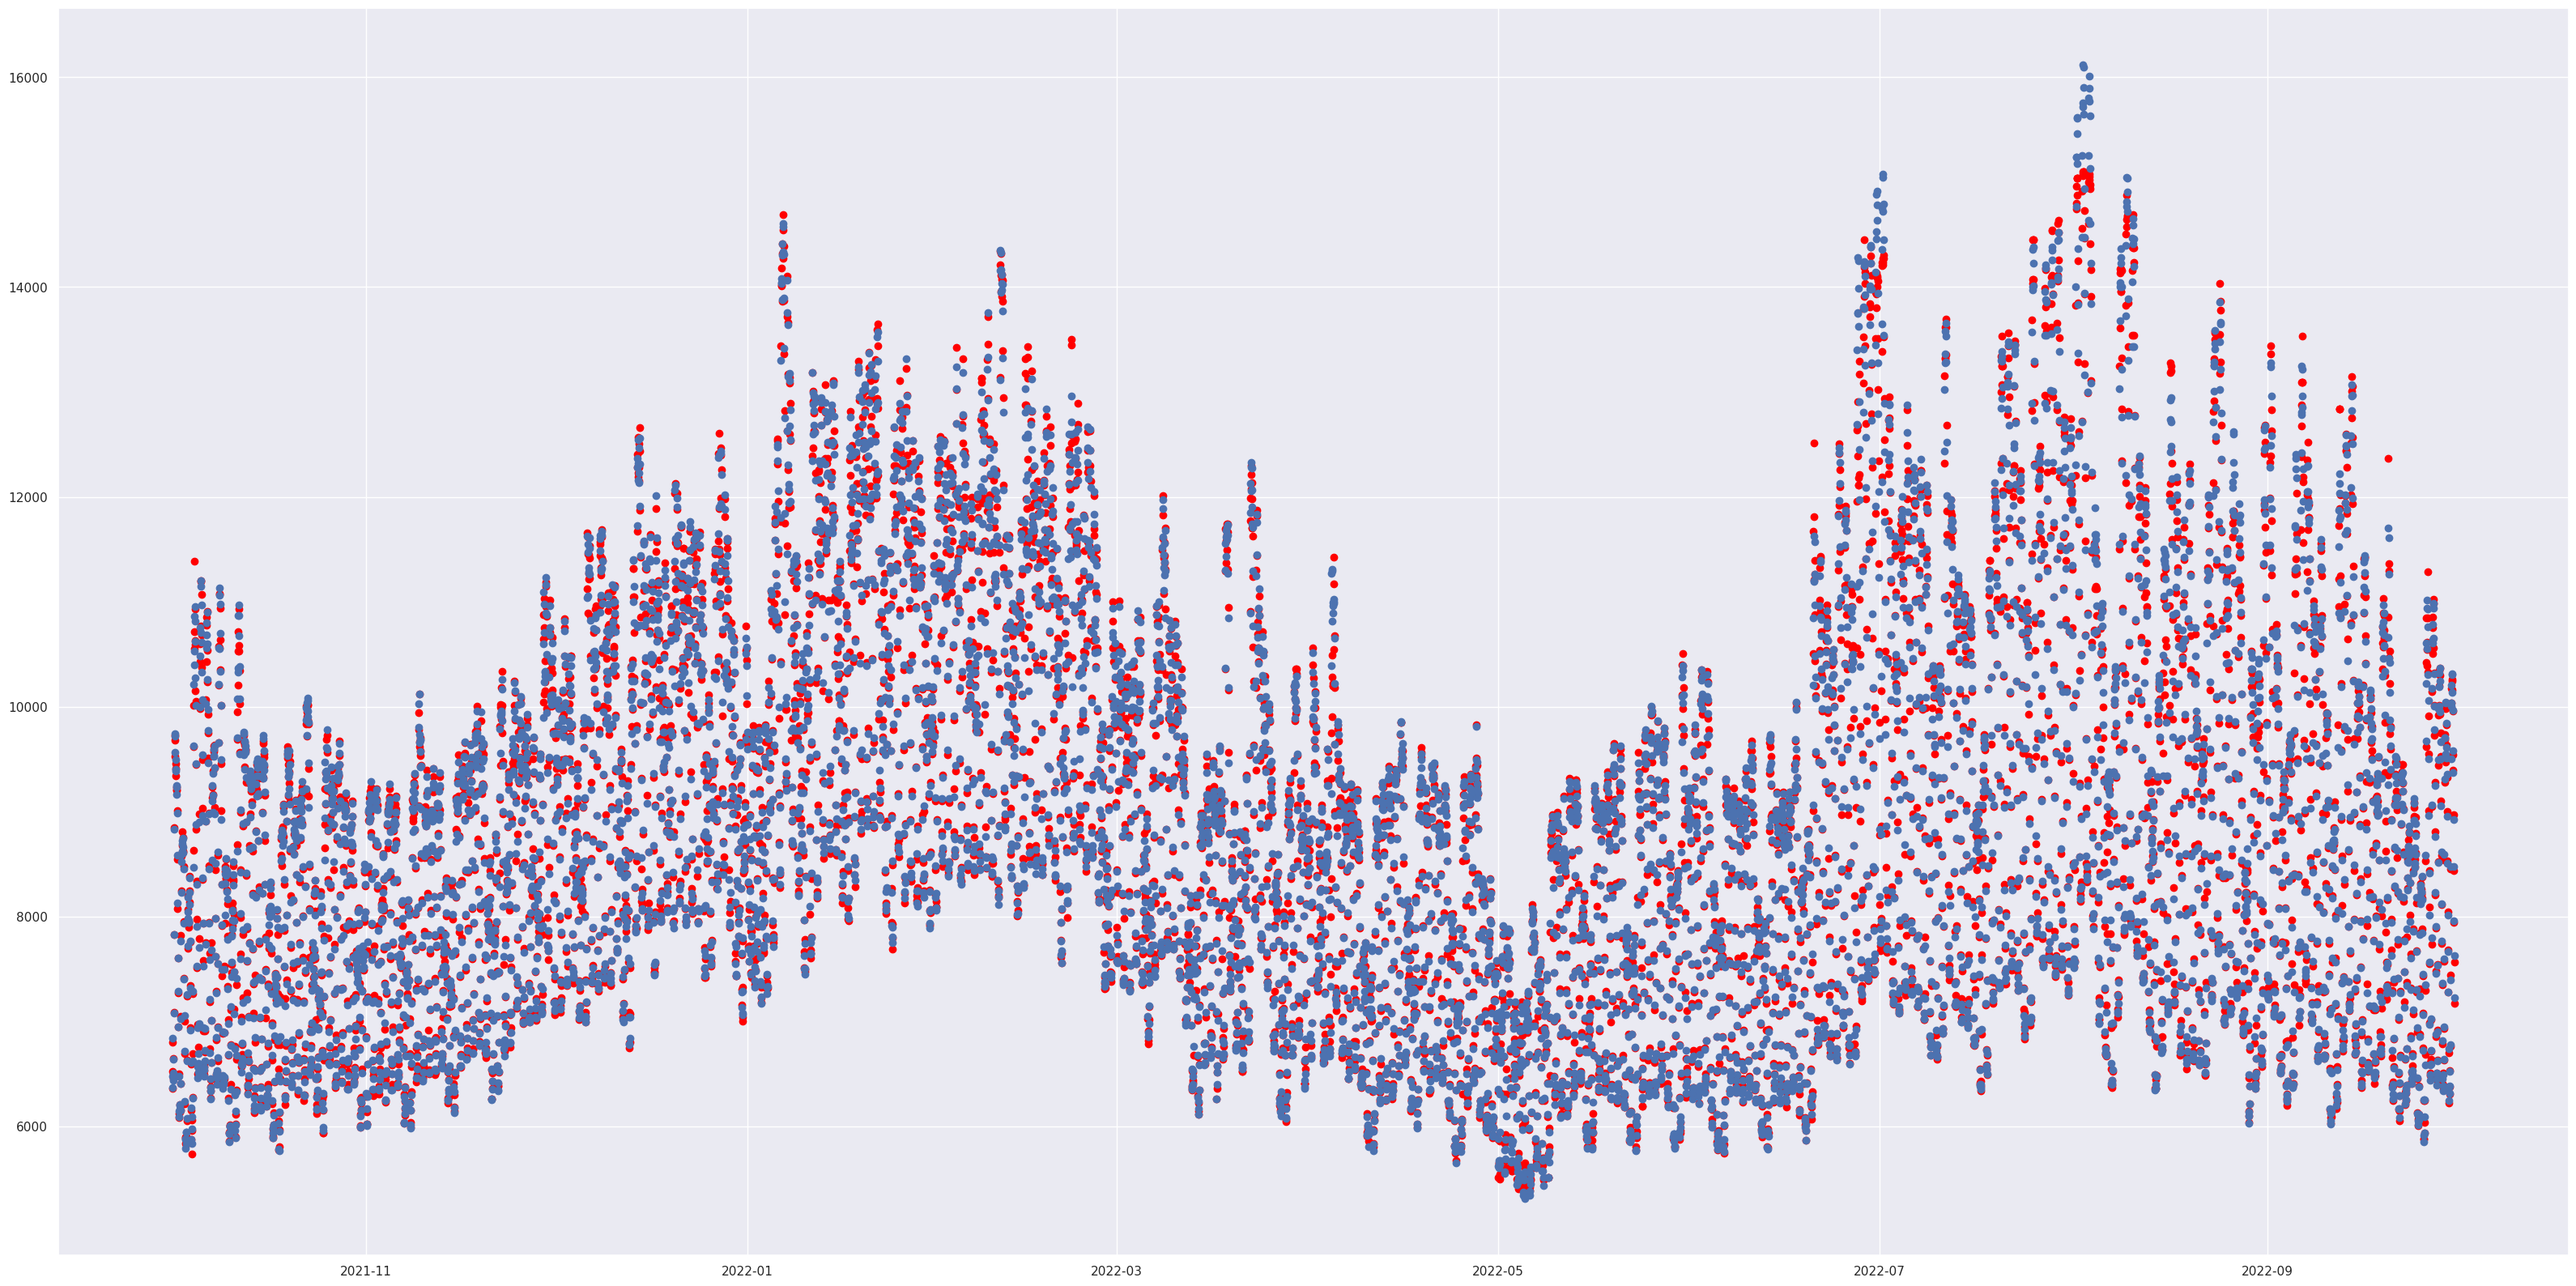

In [ ]:
plt.figure(figsize=(40,20))
#plt.plot(df_train.index, df_train['実績'].rolling(24*7).mean())
plt.scatter(df_pred.index, df_pred['実績'], color='red')
plt.scatter(df_test.index, df_test['実績'])